# Feature Engineering Homework 
***
**Name**: $<$Harshini Muthukrishnan$>$ 

**Kaggle Username**: $<$Harshini$>$
***

This assignment is due on Moodle by **5pm on Friday February 23rd**. Additionally, you must make at least one submission to the **Kaggle** competition before it closes at **4:59pm on Friday February 23rd**. Submit only this Jupyter notebook to Moodle. Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***

When people are discussing popular media, there’s a concept of spoilers. That is, critical information about the plot of a TV show, book, or movie that “ruins” the experience for people who haven’t read / seen it yet.

The goal of this assignment is to do text classification on forum posts from the website [tvtropes.org](http://tvtropes.org/), to predict whether a post is a spoiler or not. We'll be using the logistic regression classifier provided by sklearn.

Unlike previous assignments, the code provided with this assignment has all of the functionality required. Your job is to make the functionality better by improving the features the code uses for text classification.

**NOTE**: Because the goal of this assignment is feature engineering, not classification algorithms, you may not change the underlying algorithm or it's parameters

This assignment is structured in a way that approximates how classification works in the real world: Features are typically underspecified (or not specified at all). You, the data digger, have to articulate the features you need. You then compete against others to provide useful predictions.

It may seem straightforward, but do not start this at the last minute. There are often many things that go wrong in testing out features, and you'll want to make sure your features work well once you've found them.


## Kaggle In-Class Competition 
***

In addition to turning in this notebook on Moodle, you'll also need to submit your predictions on Kaggle, an online tournament site for machine learning competitions. The competition page can be found here:  

[https://www.kaggle.com/c/feature-engineering-csci-5622-spring-2018](https://www.kaggle.com/c/feature-engineering-csci-5622-spring-2018)

Additionally, a private invite link for the competition has been posted to Piazza. 

The starter code below has a `model_predict` method which produces a two column CSV file that is correctly formatted for Kaggle (predictions.csv). It should have the example Id as the first column and the prediction (`True` or `False`) as the second column. If you change this format your submissions will be scored as zero accuracy on Kaggle. 

**Note**: You may only submit **THREE** predictions to Kaggle per day.  Instead of using the public leaderboard as your sole evaluation processes, it is highly recommended that you perform local evaluation using a validation set or cross-validation. 

In [62]:
import nltk
import numpy as np
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
import matplotlib.pylab as plt
%matplotlib inline 

### [25 points] Problem 1: Feature Engineering 
***

The `FeatEngr` class is where the magic happens.  In it's current form it will read in the training data and vectorize it using simple Bag-of-Words.  It then trains a model and makes predictions.  

25 points of your grade will be generated from your performance on the the classification competition on Kaggle. The performance will be evaluated on accuracy on the held-out test set. Half of the test set is used to evaluate accuracy on the public leaderboard.  The other half of the test set is used to evaluate accuracy on the private leaderboard (which you will not be able to see until the close of the competition). 

You should be able to significantly improve on the baseline system (i.e. the predictions made by the starter code we've provided) as reported by the Kaggle system.  Additionally, the top **THREE** students from the **PRIVATE** leaderboard at the end of the contest will receive 5 extra credit points towards their Problem 1 score.


In [71]:
class FeatEngr:
    def __init__(self):
        
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.feature_extraction import text
        
        self.coeffs = []
        self.vectorizer_ngram = TfidfVectorizer( analyzer='word', ngram_range=(2, 2),stop_words='english')
        self.vectorizer = TfidfVectorizer(strip_accents = "ascii",analyzer='char_wb', ngram_range=(5, 5),sublinear_tf=True,stop_words='english')
        self.tropeTransformer = CountVectorizer()
        #self.tropeTransformer = TfidfVectorizer(analyzer='word',token_pattern='[A-Z][a-z]{1,}')
    
    
    def build_train_features(self, examples):
        """
        Method to take in training text features and do further feature engineering 
        Most of the work in this homework will go here, or in similar functions  
        :param examples: currently just a list of forum posts  
        """
        from sklearn.pipeline import FeatureUnion
        from sklearn.pipeline import Pipeline
        
        
        self.pipeline = Pipeline([('subjectbody', SubjectBodyExtractor()),
                            ('union', FeatureUnion(
                            transformer_list=
                                        [
                                            
                                                ('sentence_bow', Pipeline([
                                                ('selector', ItemSelector(key='sentence')),
                                                ('tfidf_bow', self.vectorizer),])),
                                            
                                                ('sentence_ngram', Pipeline([
                                                ('selector', ItemSelector(key='sentence')),
                                                ('tfidf_ngram', self.vectorizer_ngram),])),
                                                
                                                ('trope_transformer', Pipeline([
                                                ('selector', ItemSelector(key='trope')),
                                                ('trope', self.tropeTransformer),])),
                                                
                                                #('SentimentTransformer', Pipeline([
                                                #('selector', ItemSelector(key='sentence')),
                                                #('sentiment', SentimentTransformer()),])),
                                                
                                                #('TropeSentimentTransformer', Pipeline([
                                                #('selector', ItemSelector(key='sentence')),
                                                #('tropesentiment', TropeSentimentTransformer()),])),
                                            
                                                ('CapitalTransformer', Pipeline([
                                                ('selector', ItemSelector(key='sentence')),
                                                ('capital', CapitalTransformer()),])),
                                                
                                                ('SpecialTransformer', Pipeline([
                                                ('selector', ItemSelector(key='sentence')),
                                                ('special', SpecialTransformer()),])),
                                                
                                                #('WordCountTransformer', Pipeline([
                                                #('selector', ItemSelector(key='sentence')),
                                                #('wordcount', WordCountTransformer()),])),
                                            
                                                ('NERTransformer', Pipeline([
                                                ('selector', ItemSelector(key='sentence')),
                                                ('ner', NERTransformer()),])),
                                                
                                                #('NERTrope', Pipeline([
                                                #('selector', ItemSelector(key='trope')),
                                                #('ner_trope', TropeNERTransformer()),])),
                                            
                                                ('POS', Pipeline([
                                                ('selector', ItemSelector(key='sentence')),
                                                ('POS', POSTransformer()),])),
                                        ],)),
                            ])

        return self.pipeline.fit_transform(examples)


    def get_test_features(self, examples):
        """
        Method to ftake in test text features and transform the same way as train features 
        :param examples: currently just a list of forum posts  
        """
        return self.pipeline.transform(examples)

    def show_top10(self):
        """
        prints the top 10 features for the positive class and the 
        top 10 features for the negative class. 
        """
        capital_features = CapitalTransformer()
        ner_features = NERTransformer()
        spl_features = SpecialTransformer()
        POS_features = POSTransformer()
        spl_features.get_feature_names()
        features = self.vectorizer.get_feature_names()+self.vectorizer_ngram.get_feature_names()+self.tropeTransformer.get_feature_names()+capital_features.get_feature_names()+spl_features.get_feature_names()+ner_features.get_feature_names()+POS_features.get_feature_names() 
        feature_names = np.asarray(features)
        top10 = np.argsort(self.logreg.coef_[0])[-50:]
        bottom10 = np.argsort(self.logreg.coef_[0])[:50]
        print("Pos: %s" % " ".join(feature_names[top10]))
        print("Neg: %s" % " ".join(feature_names[bottom10]))
        
    def train_model(self, random_state=1234):
        """
        Method to read in training data from file, and 
        train Logistic Regression classifier. 
        
        :param random_state: seed for random number generator 
        """
        
        from sklearn.linear_model import LogisticRegression 
        
        # load data 
        dfTrain = pd.read_csv("../data/spoilers/train.csv")
        
        # get training features and labels 
        self.X_train = self.build_train_features(dfTrain)
        self.y_train = np.array(dfTrain["spoiler"], dtype=int)
        
        # train logistic regression model.  !!You MAY NOT CHANGE THIS!! 
        self.logreg = LogisticRegression(random_state=random_state)
        self.logreg.fit(self.X_train, self.y_train)
        self.coeffs = self.logreg.coef_[0]
        
    def model_predict(self):
        """
        Method to read in test data from file, make predictions
        using trained model, and dump results to file 
        """
        
        # read in test data 
        dfTest  = pd.read_csv("../data/spoilers/test.csv")
        
        # featurize test data 
        self.X_test = self.get_test_features(dfTest)
        
        # make predictions on test data 
        pred = self.logreg.predict(self.X_test)
        
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(self.logreg, self.X_train, self.y_train, cv=6)
        print("\nTFIDF Crossvalidation Scores: ",end=" ")
        print(scores)
        print("TFIDF Mean Accuracy in Cross-Validation = {:.3f}".format(scores.mean()))
        
        # dump predictions to file for submission to Kaggle  
        pd.DataFrame({"spoiler": np.array(pred, dtype=bool)}).to_csv("prediction.csv", index=True, index_label="Id")
    

In [72]:
# Instantiate the FeatEngr clas 
feat = FeatEngr()

# Train your Logistic Regression classifier 
feat.train_model(random_state=1230)

# Shows the top 10 features for each class 
feat.show_top10()

# Make prediction on test data and produce Kaggle submission file 
feat.model_predict()


Pos:  back scifiwritershavenosenseofscale  his  anyonecandie cliffhanger  as  andimustscream disneydeath promotiontoparent soundtrackdissonance cliffhangercopout anguisheddeclarationoflove reallifewritestheplot batmangambit everybodyissingle furagainstfang secretkeeper  it  alljustadream itspersonal noending hopespot heroicsacrifice attemptedrape neverfoundthebody backfromthedead parentalabandonment corruptcorporateexecutive villainousbreakdown chekhovsgun stabletimeloop deadallalong heroicbsod nicejobbreakingithero nonamegiven themole  her   out  driventosuicide killedoffforreal ohcrap thereveal bittersweetending foreshadowing whamline xanatosgambit whamepisode  he   ,   . 
Neg:  show deadpansnarker show  domcom catchphrase abc spinoff  i  flanderization gilligancut theotherdarrin thecastshowoff  ofte heyitsthatguy gameshow  usua often stockfootage like  usual thebbc catfight nbc celebrityparadox bitcharacter  one  itsawonderfulplot fantasticcomedy nicehat gettingcrappasttheradar  dre

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
from scipy.sparse import csr_matrix
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

class SubjectBodyExtractor(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        
        features = np.recarray(shape=(len(data),),
                               dtype=[('sentence', object), ('trope', object)])
        features['sentence'] = list(data['sentence'])
        features['trope'] = list(data['trope'])

        return features

class SentimentTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self

    def transform(self, examples):
        sentiment = ['compound']
        #sentiment = ['neu']
        X = np.zeros((len(examples), len(sentiment)))
        s=sia()
        for counter, example in enumerate(examples):
            res = s.polarity_scores(example)
            X[counter,:] = np.array([res.get(k) for k in sentiment])
        return csr_matrix(X)
    
class TropeSentimentTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        pass
    
    def fit(self, x, y=None):
        return self

    def transform(self, examples):
        sentiment = ['pos','neg','neu']
        X = np.zeros((len(examples), len(sentiment)))
        s=sia()
        for counter, example in enumerate(examples):
            res = s.polarity_scores(" ".join(re.sub( r"([A-Z])", r" \1", example).split()))
            X[counter,:] = np.array([res.get(k) for k in sentiment])
        return csr_matrix(X)

class CapitalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.feature_names = ["NumOfCapitalLetters"]
        pass
    
    def fit(self, x, y=None):
        return self
    
    def get_feature_names(self):
        return self.feature_names
    
    def transform(self, examples):
        X = np.zeros((len(examples), 1))
        for counter, example in enumerate(examples):
            X[counter,:] = np.array([sum(1 for c in example if c.isupper())])
        return csr_matrix(X)

class SpecialTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.feature_names = ["dead", "die",  "kill", "killed", "suicide", "shot", "staked", "stabbed", "finale","died", "dies", "dying", "death", "survived", "survive", "stab", "revealed", "realize", "realizes",  "averted", "averts", "finally", "final", "alive", "murder", "murdered", "murderer", "killer", "learns", "married", "marries", "wedding", "realizes", "actually", "!", "pregnant", "end", "ending", "killing", "kills", "eventually", "reason", "discover", "discovered", "shoot", "truth", "ultimately"]  
        pass
    
    def fit(self, x, y=None):
        return self
    
    def get_feature_names(self):
        return self.feature_names
    
    def transform(self, examples):
        wnl = WordNetLemmatizer()
        letters = ["dead", "die",  "kill", "killed", "suicide", "shot", "staked", "stabbed", "finale","died", "dies", "dying", "death", "survived", "survive", "stab", "revealed", "realize", "realizes",  "averted", "averts", "finally", "final", "alive", "murder", "murdered", "murderer", "killer", "learns", "married", "marries", "wedding", "realizes", "actually", "!", "pregnant", "end", "ending", "killing", "kills", "eventually", "reason", "discover", "discovered", "shoot", "truth", "ultimately"]  
        X = np.zeros ((len(examples), len(letters)))
        for counter, example in enumerate(examples):
            #doc_prepped = [wnl.lemmatize(t) for t in word_tokenize(example)]
            #count = len(letters.intersection(doc_prepped))
            #X[counter,:] = np.array(count)
            X[counter,:] = np.array([example.count(letter) for letter in letters])
        return csr_matrix(X)
    
class WordCountTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self

    def transform(self, examples):
        X = np.zeros((len(examples), 1))
        for counter, example in enumerate(examples):
            X[counter,:] = np.array(len(example.split()))
        return csr_matrix(X)

class NERTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.feature_names = ["B-PERSON","I-PERSON","B-ORGANIZATION","I-ORGANIZATION"]
        pass
    
    def fit(self, x, y=None):
        return self
    
    def get_feature_names(self):
        return self.feature_names
    
    def transform(self, examples):
        from nltk import word_tokenize, pos_tag, ne_chunk
        from nltk.chunk import tree2conlltags
        
        types=['B-PERSON','I-PERSON','B-ORGANIZATION','I-ORGANIZATION']
        X = np.zeros((len(examples), len(types)))
        for counter, example in enumerate(examples):
            ne_tree = ne_chunk(pos_tag(word_tokenize(example)))
            iob_tagged = tree2conlltags(ne_tree)
            iob_string = " ".join(x[2] for x in iob_tagged)
            X[counter,:] = np.array([iob_string.count(t) for t in types])
        return csr_matrix(X)

class TropeNERTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, examples):
        self.feature_names = ["B-PERSON","I-PERSON","B-ORGANIZATION","I-ORGANIZATION"]
        
        types=['B-PERSON','I-PERSON','B-ORGANIZATION','I-ORGANIZATION']
        X = np.zeros((len(examples), len(types)))
        for counter, example in enumerate(examples):
            ne_tree = ne_chunk(pos_tag(re.sub( r"([A-Z])", r" \1", example).split()))
            iob_tagged = tree2conlltags(ne_tree)
            iob_string = " ".join(x[2] for x in iob_tagged)
            X[counter,:] = np.array([iob_string.count(t) for t in types])
        return csr_matrix(X)

class POSTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.feature_names = ['VB','NN','NNP','VBZ']
        pass
    def get_feature_names(self):
        return self.feature_names
    
    def fit(self, x, y=None):
        return self

    def transform(self, examples):
        from nltk.data import load
        tagdict = load('help/tagsets/upenn_tagset.pickle')
        
        
        #tags = [k for k in tagdict.keys()]
        tags = ['VB','NN','NNP','VBZ']
        X = np.zeros((len(examples), len(tags)))
        for counter, example in enumerate(examples):
            example_tags = list(word_tag_tuple[1] for word_tag_tuple in nltk.pos_tag(word_tokenize(example)))
            X[counter,:] = np.array([example_tags.count(letter) for letter in tags])
        return csr_matrix(X)      

### [25 points] Problem 2: Motivation and Analysis 
***

The job of the written portion of the homework is to convince the grader that:

- Your new features work
- You understand what the new features are doing
- You had a clear methodology for incorporating the new features

Make sure that you have examples and quantitative evidence that your features are working well. Be sure to explain how you used the data (e.g., did you have a validation set? did you do cross-validation?) and how you inspected the results. In addition, it is very important that you show some kind of an **error analysis** throughout your process.  That is, you should demonstrate that you've looked at misclassified examples and put thought into how you can craft new features to improve your model. 

A sure way of getting a low grade is simply listing what you tried and reporting the Kaggle score for each. You are expected to pay more attention to what is going on with the data and take a data-driven approach to feature engineering.

For the features explored, I used a cross validation over the train set. I used a cross validation fold of 5, which splits the training set into 5 equal samples. I kept records of the features and parameters used, along with their accuracy.

I started with the baseline model, assessed the overall accuracy and found the most influential features, and also inspected the top50 influential features for both the classes. Based on false positives and false negatives, I tried to design features to reduce those errors.

**Features I explored were:**
* Bag of words on the sentence using TfidfVectorizer
* Bag of characters on the sentence using TfidfVectorizer
* Bag of words on the trope using CountVectorizer
* Sentiment analysis on the sentence
* Named Entity Recognition on the sentences
* Part of Speech Tagging
* Manual observation of training data
* Capital letters in sentence

**Reasons for choosing different features**

**1. Bag of words on the sentence using TfidfVectorizer:**

The baseline system used CountVectorizer as a bag of words model. For any text classification task, the bag of words from the training set will be a good fit as a feature. But the CountVectorizer just counts the word frequencies. Simple as that. With the TFIDFVectorizer the value increases proportionally to count, but is offset by the frequency of the word in the corpus. This helps to adjust for the fact that some words appear more frequently. A collection of unigrams (what bag of words is) cannot capture phrases and multi-word expressions, effectively disregarding any word order dependence. Instead of building a simple collection of unigrams (n=1), one might prefer a collection of bigrams (n=2), where occurrences of pairs of consecutive words are counted. Using Tfidf instead of the CountVectorizer gave a good accuracy. It increased from 0.62 in baseline to 0.64.


**2. Bag of characters on the sentence using TfidfVectorizer:**

The bag of words model doesn’t account for potential misspellings or word derivations. We can alternatively consider a collection of character n-grams, a representation resilient against misspellings and derivations. char_wb is used to pad the characters on each side with a whitespace. char_wb is especially interesting for languages that use white-spaces for word separation as it generates significantly less noisy features than the raw char variant in that case. For such languages it can increase both the predictive accuracy and convergence speed of classifiers trained using such features while retaining the robustness with regards to misspellings and word derivations. The bad of words on characters was a good choice for the training data at hand since it is highly possible to see noise in data extracted form tropes. The accuracy inturn increased from 0.64 to 0.68.


**3. Bag of words on the trope using CountVectorizer:**

Using trope as a feature resulted in a very high accuracy prediction. The accuracy jumped from .68 to .70. Analysing the data, we find that explicitly stated content(spoiler) have similar tropes. This is the reason for the trope giving high accuracy. On observing the top few features, it is seen that trope has occured in both the positive and negative top features. It is thus clear that trope is a heavy influencer for the training and validation data.

**4. Sentiment analysis on the sentence:**

Analysing the sentiment of the sentence helps with analysing the category of it. Sentiment analysis as a text classification task is an example of this. So on a similar note, analysing the sentiment was thought of as a feature and implemented. This however didnt improve the accuracy much on the training data but on the test data the accuracy remained the same. Hence to avoid overfitting, the feature wasn't considered.

**5. Named Entity Recognition on the sentences**

Named entity recognition is used to get the proper nouns like Persons and organizations from a text. It is related to Part of Speech Tagging. So finding the this should tell more about the underlying contextual meaning of the nouns in the sentence. Implementing this improved the accuracy by 0.2

**6. Part of Speech Tagging**

Part of Speech tagging helps with identifying the context of the sentence. Rather than looking at the entriety of vocabulary, we can focus on the 45 tags associated with every word in the vocabulary. This fetaure implemented gave a really good accuracy improvement since it will try to reduce the overfitting due to specific words and concentrate on the general case of the vocabulary by only considering the part of speech unique to that sentence.

**7.Manual observation of training data**

This is hand extraction of features using the training data at hand. We can look at the training data and find the features that are most important for both the classes and occur most frequently in both of them to handpick them. I did this and picked up a set of features to add to my list and this improved my accuracy by 0.1.

**8. Capital letters in sentence**

The number of capital letters was a good indictaion and also improved accuracy beacuse it is a form of exclamation when narrating a text. When we convert a spoken dialogue from a tv serial into written form we naturally tend to capitalize to stress the importance of certain words in the situation. Hence this led to an improved accuracy on test data.

**Reference:**

http://scikit-learn.org

The graph below is a histogram which shows the distribution of weights that were found by fitting the data to the logistic regression model. This looks like a normally distributed graph and since ML models assume that your input features are generally normally distributed the graph below is a good example if this concept.

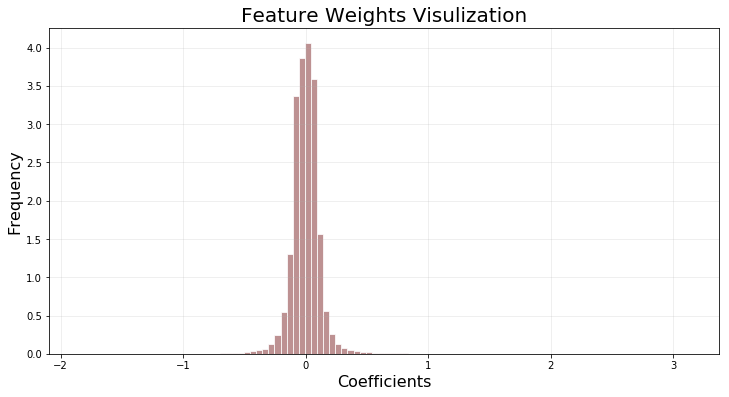

In [54]:
mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
values = [i for i in sorted(feat.coeffs) if i<4]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
n, bins, patches = ax.hist(values, 100, normed=1, facecolor=mycolors["red"], alpha=0.75, edgecolor="white")
ax.set_xlabel("Coefficients", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16);
ax.set_title("Feature Weights Visulization", fontsize=20);
ax.grid(alpha=0.25)

### Hints 
***

- Don't use all the data until you're ready. 

- Examine the features that are being used.

- Do error analyses.

- If you have questions that aren’t answered in this list, feel free to ask them on Piazza.

### FAQs 
***

> Can I heavily modify the FeatEngr class? 

Totally.  This was just a starting point.  The only thing you cannot modify is the LogisticRegression classifier.  

> Can I look at TV Tropes?

In order to gain insight about the data yes, however, your feature extraction cannot use any additional data (beyond what I've given you) from the TV Tropes webpage.

> Can I use IMDB, Wikipedia, or a dictionary?

Yes, but you are not required to. So long as your features are fully automated, they can use any dataset other than TV Tropes. Be careful, however, that your dataset does not somehow include TV Tropes (e.g. using all webpages indexed by Google will likely include TV Tropes).

> Can I combine features?

Yes, and you probably should. This will likely be quite effective.

> Can I use Mechanical Turk?

That is not fully automatic, so no. You should be able to run your feature extraction without any human intervention. If you want to collect data from Mechanical Turk to train a classifier that you can then use to generate your features, that is fine. (But that’s way too much work for this assignment.)

> Can I use a Neural Network to automatically generate derived features? 

No. This assignment is about your ability to extract meaningful features from the data using your own experimentation and experience.

> What sort of improvement is “good” or “enough”?

If you have 10-15% improvement over the baseline (on the Public Leaderboard) with your features, that’s more than sufficient. If you fail to get that improvement but have tried reasonable features, that satisfies the requirements of assignment. However, the extra credit for “winning” the class competition depends on the performance of other students.

> Where do I start?  

It might be a good idea to look at the in-class notebook associated with the Feature Engineering lecture where we did similar experiments. 


> Can I use late days on this assignment? 

You can use late days for the write-up submission, but the Kaggle competition closes at **4:59pm on Friday February 23rd**

> Why does it say that the competition ends at 11:59pm when the assignment says 4:59pm? 

The end time/date are in UTC.  11:59pm UTC is equivalent to 4:59pm MST.  Kaggle In-Class does not allow us to change this. 